## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from river import drift

import random
from sklearn.metrics import roc_auc_score, roc_curve

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

#### Insect dataset

1000 train originally

In [5]:
full_df = pd.read_csv("../data/insects_full.data", header=None)#.rename(columns={'period': 'period_original'})
full_df.columns = [f'feat_{c+1}' for c in full_df.columns]
full_df = full_df.rename(columns={full_df.columns[-1]: 'class'})

In [6]:
cols_1 = full_df.iloc[7000:15000, :50]
cols_2 = full_df.iloc[7000:15000, 50:100]

In [7]:
full_df.iloc[7000:15000, :50] = cols_2.values
full_df.iloc[7000:15000, 50:100] = cols_1.values

In [8]:
full_df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_192,feat_193,feat_194,feat_195,feat_196,feat_197,feat_198,feat_199,feat_200,class
0,0.008025,0.014296,0.012436,0.012884,0.011645,0.011120,0.009875,0.008933,0.007779,0.006801,...,0.001997,0.002404,0.002873,0.003257,0.003767,0.004020,0.004582,0.004522,0.005381,3
1,0.001678,0.002237,0.001822,0.001860,0.001540,0.001875,0.002031,0.002105,0.001902,0.001857,...,0.003370,0.003999,0.004597,0.005053,0.005758,0.006159,0.006886,0.006614,0.007420,3
2,0.000182,0.000363,0.000375,0.000699,0.000940,0.001272,0.001663,0.001953,0.002331,0.002553,...,0.008477,0.009437,0.009902,0.009649,0.008894,0.008001,0.008250,0.008525,0.008820,3
3,0.003522,0.006619,0.005727,0.005593,0.004897,0.004824,0.004742,0.004629,0.004141,0.003831,...,0.000907,0.001009,0.001442,0.002044,0.002830,0.003368,0.004072,0.004118,0.004759,3
4,0.004392,0.006899,0.005102,0.005211,0.004720,0.004711,0.004321,0.004206,0.004136,0.004373,...,0.002569,0.002711,0.002845,0.002907,0.002993,0.002925,0.002984,0.002718,0.002878,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.000149,0.000179,0.000122,0.000123,0.000099,0.000111,0.000092,0.000099,0.000094,0.000083,...,0.001408,0.001759,0.002691,0.003631,0.004308,0.003796,0.003359,0.002965,0.005204,3
86396,0.000533,0.001133,0.001245,0.001588,0.001927,0.002283,0.002571,0.002877,0.002972,0.002971,...,0.000411,0.000486,0.000564,0.000596,0.000649,0.000650,0.000755,0.000773,0.001106,3
86397,0.007268,0.011191,0.007570,0.006760,0.005072,0.004677,0.003920,0.003445,0.002537,0.001724,...,0.000536,0.000584,0.000637,0.000674,0.000733,0.000749,0.000827,0.000802,0.000957,3
86398,0.000005,0.000009,0.000008,0.000008,0.000007,0.000007,0.000008,0.000011,0.000014,0.000016,...,0.000185,0.000111,0.000064,0.000037,0.000022,0.000015,0.000010,0.000007,0.000008,1


<AxesSubplot:>

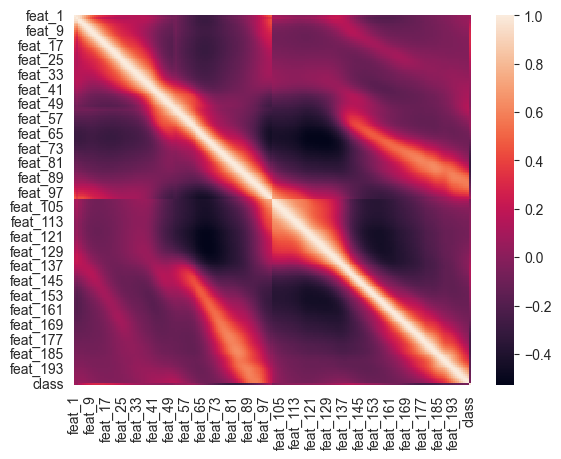

In [9]:
sns.heatmap(full_df.corr())

In [10]:
#full_df['class'] = np.where(full_df['class']=='UP', 1, 0)

In [11]:
cat_features = []

In [12]:
numeric_features = full_df.columns

In [13]:
# model_cicids = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           1       0.99      0.31      0.47     28749
           2       1.00      0.96      0.98     28756
           3       0.36      1.00      0.53     11615

    accuracy                           0.69     69120
   macro avg       0.78      0.76      0.66     69120
weighted avg       0.89      0.69      0.69     69120

Accuracy: 0.6948640046296296


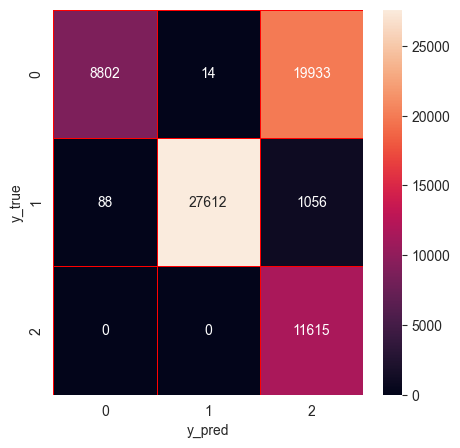

In [14]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = full_df.drop(['class'],axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.2, test_size = 0.8, shuffle=False, random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [15]:
top_feats_df = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [16]:
top_feats_df

,Value,Feature
100,246,feat_101
116,185,feat_117
104,141,feat_105
40,124,feat_41
113,116,feat_114
...,...,...
32,17,feat_33
96,17,feat_97
71,16,feat_72
44,15,feat_45


In [17]:
top_feats = top_feats_df.Feature.tolist() #top_feats = top_feats_df.Feature.tolist() #

In [18]:
full_df_reduced = full_df[top_feats]

In [19]:
column_mapping_adult = {
    "target": "class",
    "numerical_features": full_df_reduced.columns,
    "categorical_features": [],
}

In [20]:
CT_dataset = Dataset(
    full_df=full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=1000
)

In [21]:
CT_dataset.full_df

,feat_101,feat_117,feat_105,feat_41,feat_114,feat_102,feat_200,feat_109,feat_107,feat_106,...,feat_181,feat_138,feat_84,feat_175,feat_124,feat_33,feat_97,feat_72,feat_45,feat_78
0,0.000461,0.003849,0.000542,0.006049,0.002846,0.000454,0.005381,0.001188,0.000766,0.000631,...,0.000262,0.004211,0.001896,0.000316,0.004825,0.000978,0.000647,0.008661,0.012009,0.004008
1,0.000300,0.003176,0.000878,0.002499,0.004076,0.000397,0.007420,0.001925,0.000887,0.000880,...,0.000987,0.004267,0.000369,0.000273,0.011750,0.002164,0.000331,0.002349,0.006660,0.000188
2,0.000521,0.005053,0.000995,0.004687,0.004634,0.000516,0.008820,0.001790,0.001347,0.001043,...,0.001187,0.001369,0.000110,0.000689,0.014512,0.002946,0.000405,0.002435,0.015218,0.000502
3,0.002665,0.001371,0.003180,0.005346,0.001710,0.002862,0.004759,0.002902,0.003103,0.003169,...,0.001010,0.009089,0.000997,0.000671,0.009049,0.000820,0.002255,0.008982,0.012516,0.003042
4,0.001381,0.002868,0.001919,0.006600,0.002767,0.001470,0.002878,0.002482,0.002203,0.002062,...,0.001232,0.005993,0.000816,0.000529,0.003785,0.001262,0.001090,0.006171,0.013363,0.002399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.000312,0.003220,0.001156,0.001615,0.003609,0.000407,0.005204,0.002757,0.001956,0.001546,...,0.000438,0.004070,0.000037,0.000063,0.025271,0.001464,0.000106,0.002444,0.002800,0.000088
86396,0.000090,0.001388,0.000040,0.002001,0.001050,0.000064,0.001106,0.000207,0.000092,0.000056,...,0.000045,0.026778,0.000546,0.000029,0.003058,0.000354,0.000113,0.002621,0.003071,0.002366
86397,0.000584,0.000178,0.000430,0.005400,0.000136,0.000494,0.000957,0.000421,0.000448,0.000441,...,0.000193,0.004854,0.006646,0.000895,0.001268,0.003292,0.001351,0.015284,0.008113,0.011053
86398,0.000740,0.000066,0.000951,0.000029,0.000150,0.000859,0.000008,0.000571,0.000801,0.000892,...,0.005322,0.002275,0.003326,0.013483,0.000052,0.000027,0.000233,0.021715,0.000021,0.011241


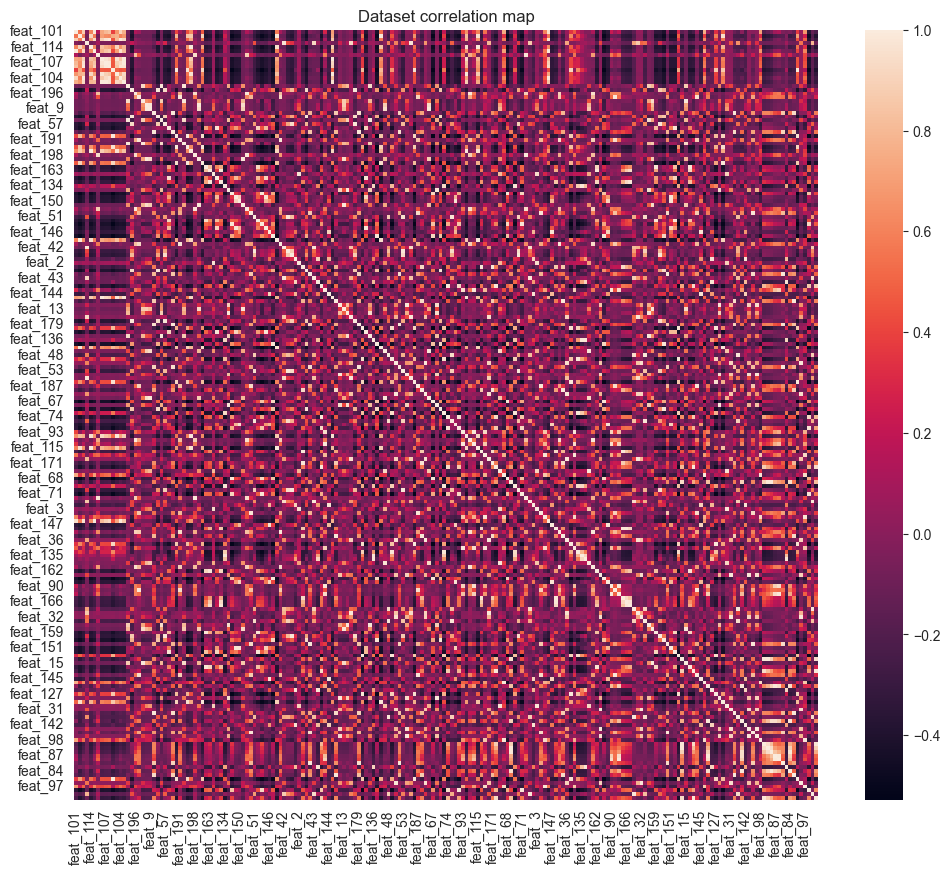

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(CT_dataset.full_df.corr(), annot=False)

plt.title('Dataset correlation map')
plt.show()

## Run Experiments

In [23]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [24]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [25]:
#corr_dict = windowed_correlation(CT_dataset.full_df.loc[:, CT_dataset.full_df.columns], mode='expanding')

In [26]:
#plot_windowed_correlation(corr_dict)

In [27]:
column_names = list(CT_dataset.reference_df.columns)

In [28]:
len(column_names)

202

In [29]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=1000,
)

calc.fit(CT_dataset.reference_df)

In [30]:
results = calc.calculate(CT_dataset.analysis_df)

In [31]:
results_js = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]

In [32]:
display(results_js.iloc[18:21])

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,feat_101_jensen_shannon_value,feat_101_jensen_shannon_upper_threshold,feat_101_jensen_shannon_lower_threshold,...,feat_45_jensen_shannon_lower_threshold,feat_45_jensen_shannon_alert,feat_78_jensen_shannon_value,feat_78_jensen_shannon_upper_threshold,feat_78_jensen_shannon_lower_threshold,feat_78_jensen_shannon_alert,sample_num_jensen_shannon_value,sample_num_jensen_shannon_upper_threshold,sample_num_jensen_shannon_lower_threshold,sample_num_jensen_shannon_alert
18,[18000:18999],18,18000,18999,None,None,analysis,0.116946,0.1,None,...,None,True,0.080430,0.1,None,False,1.0,0.1,None,True
19,[19000:19999],19,19000,19999,None,None,analysis,0.221261,0.1,None,...,None,False,0.073079,0.1,None,False,1.0,0.1,None,True
20,[20000:20999],20,20000,20999,None,None,analysis,0.429277,0.1,None,...,None,True,0.183041,0.1,None,True,1.0,0.1,None,True


In [33]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]]

,feat_101_jensen_shannon_value,feat_117_jensen_shannon_value,feat_105_jensen_shannon_value,feat_41_jensen_shannon_value,feat_114_jensen_shannon_value,feat_102_jensen_shannon_value,feat_200_jensen_shannon_value,feat_109_jensen_shannon_value,feat_107_jensen_shannon_value,feat_106_jensen_shannon_value,...,feat_138_jensen_shannon_value,feat_84_jensen_shannon_value,feat_175_jensen_shannon_value,feat_124_jensen_shannon_value,feat_33_jensen_shannon_value,feat_97_jensen_shannon_value,feat_72_jensen_shannon_value,feat_45_jensen_shannon_value,feat_78_jensen_shannon_value,sample_num_jensen_shannon_value
0,0.089759,0.129938,0.080774,0.102311,0.118293,0.095338,0.123681,0.098682,0.097078,0.088661,...,0.169518,0.140253,0.144441,0.159137,0.059776,0.083302,0.138053,0.156736,0.094212,0.998009
1,0.109833,0.101219,0.110760,0.073772,0.091853,0.119260,0.063475,0.079497,0.103074,0.113229,...,0.132822,0.117360,0.129021,0.122887,0.068582,0.095489,0.081012,0.134494,0.058102,1.000000
2,0.103043,0.087980,0.107980,0.084226,0.088415,0.116396,0.074248,0.102275,0.109794,0.113122,...,0.145662,0.117295,0.081556,0.095339,0.114279,0.062247,0.120089,0.077511,0.113294,1.000000
3,0.081341,0.079627,0.087812,0.028696,0.083538,0.082006,0.056990,0.066895,0.084639,0.090998,...,0.055256,0.057942,0.078142,0.066190,0.035314,0.069228,0.053094,0.040964,0.061415,1.000000
4,0.073205,0.135315,0.078500,0.104975,0.105382,0.068169,0.120165,0.089760,0.091346,0.090524,...,0.156885,0.126035,0.140635,0.150711,0.047457,0.076406,0.134914,0.149461,0.091505,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.177818,0.170319,0.181656,0.079633,0.164485,0.192107,0.080184,0.180956,0.178346,0.188940,...,0.129192,0.119251,0.066986,0.157531,0.124157,0.143714,0.153809,0.069822,0.108530,1.000000
81,0.120003,0.122024,0.118759,0.058513,0.121924,0.117322,0.072284,0.125328,0.124104,0.131051,...,0.097515,0.086410,0.081636,0.101617,0.073082,0.092883,0.112412,0.071579,0.083926,1.000000
82,0.111141,0.137099,0.100091,0.064332,0.120642,0.115126,0.094905,0.104318,0.115145,0.109659,...,0.114407,0.080103,0.086682,0.114644,0.051149,0.065818,0.101334,0.102960,0.059614,1.000000
83,0.087901,0.121935,0.088723,0.100189,0.089505,0.108659,0.092371,0.091909,0.078388,0.090368,...,0.155019,0.132563,0.149687,0.138142,0.050611,0.065846,0.124586,0.153338,0.075747,1.000000


<AxesSubplot:>

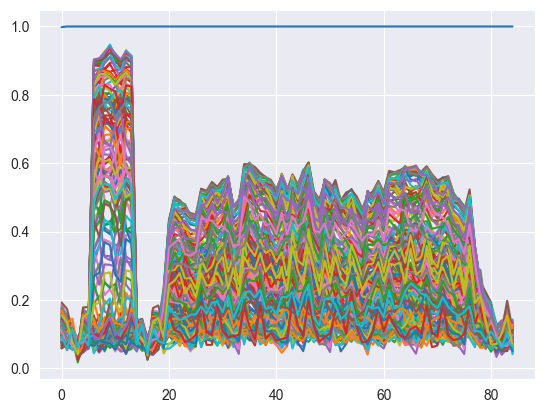

In [34]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]].plot(legend=False)
#plt.legend(bbox_to_anchor=(1, 0.5))

In [35]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

In [36]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### ADWIN detector

In [65]:
# using ADWIN drift detector to find the change points on each feature by iterating through every column of CT_dataset.full_df


adwin = drift.ADWIN()
all_drift = []

for col in CT_dataset.full_df.columns:
    adwin = drift.ADWIN()
    feat = CT_dataset.full_df[col]
    for i, val in enumerate(feat):
        _ = adwin.update(val)
        if adwin.drift_detected:
            print(f"Change detected at index {i}, input value: {val}")
            all_drift.append(i)

Change detected at index 65535, input value: 0.0016488
Change detected at index 31711, input value: 0.0037174
Change detected at index 22335, input value: 0.0010864
Change detected at index 40703, input value: 9.1609e-05
Change detected at index 67711, input value: 0.030285
Change detected at index 80735, input value: 0.0010015
Change detected at index 22559, input value: 0.00036976
Change detected at index 36895, input value: 0.013544
Change detected at index 69503, input value: 0.00050284
Change detected at index 81791, input value: 0.00036818
Change detected at index 34175, input value: 0.0027068
Change detected at index 24927, input value: 0.0020254
Change detected at index 84095, input value: 0.00032763
Change detected at index 22751, input value: 0.012834
Change detected at index 40127, input value: 0.013139
Change detected at index 78975, input value: 0.010736
Change detected at index 22431, input value: 4.5855e-05
Change detected at index 38655, input value: 0.00066965
Change d

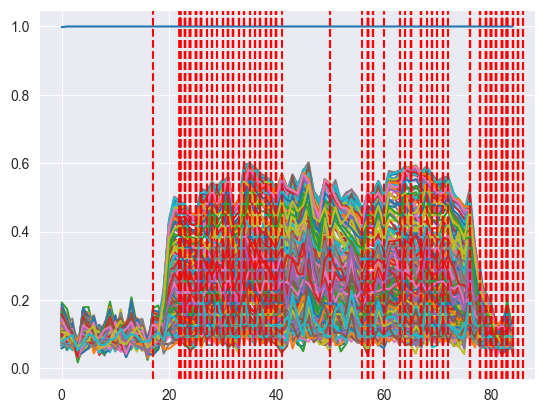

In [66]:
plt.plot(results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]])

for i in all_drift:
    plt.axvline(x=int(i/1000), color='red', linestyle='--')

plt.show()

In [68]:
np.sort(all_drift)

array([17439, 22079, 22111, 22143, 22175, 22175, 22175, 22207, 22207,
       22207, 22239, 22239, 22303, 22335, 22335, 22367, 22399, 22399,
       22399, 22431, 22463, 22495, 22527, 22559, 22559, 22623, 22623,
       22655, 22751, 22751, 22783, 22911, 22911, 22911, 23103, 23103,
       23167, 23391, 23391, 23423, 23711, 23807, 23967, 24159, 24255,
       24287, 24319, 24351, 24383, 24511, 24543, 24575, 24575, 24575,
       24575, 24575, 24575, 24767, 24927, 25375, 25375, 25471, 25471,
       25599, 25599, 25599, 25599, 25631, 25695, 25951, 25983, 26079,
       26143, 26367, 26399, 26463, 26623, 26623, 26623, 26623, 26623,
       26623, 26623, 27295, 27519, 28095, 28223, 28671, 28671, 28703,
       29055, 30047, 30079, 30239, 30719, 31487, 31647, 31647, 31711,
       31743, 31935, 31967, 32159, 32511, 32543, 32671, 32767, 32767,
       32895, 33119, 33311, 33599, 34111, 34175, 34463, 34687, 35487,
       35679, 35935, 36287, 36671, 36895, 36895, 37375, 37471, 37503,
       37567, 37727,

### Own Jensen-Shannon

In [196]:
chg_points = [17000] # JS
# chg_points = [17439, 79000] # ADWIN

CT_dataset.add_changepoints(chg_points)
rad_left = 5000
rad_right = 5000

In [197]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
display(dde_exp_eq_radius.results_all)

12000 17000 22000


,start,change_point,end,feat_101,feat_117,feat_105,feat_41,feat_114,feat_102,feat_200,...,feat_138,feat_84,feat_175,feat_124,feat_33,feat_97,feat_72,feat_45,feat_78,sample_num
0,12000,17000,22000,0.123327,0.149552,0.133347,0.030148,0.145832,0.128591,0.057603,...,0.038343,0.229761,0.045705,0.133282,0.296018,0.281414,0.400572,0.136367,0.303197,0.999504


In [198]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=rad_left, radius_right=rad_right)

12000 17000 22000


#### Change point 1

In [199]:
detector = 'js'

with pd.ExcelWriter(f'outputs/insects_fake/CD_delta_vs_ro_chp_tabs_{detector}.xlsx') as writer:

    for chp in CT_dataset.change_points:
        drift_threshold = 0.3
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        # combin!!!!
        for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            if feat1 != feat2:
                summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['single_feat_drift'] = np.where(summary_df['feat_1_drift'] ^ summary_df['feat_2_drift'], 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

In [200]:
summary_df = summary_df.sort_values(by=['feat_1_cd_score'], ascending=False)

In [201]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,single_feat_drift,feat_pair_drift
3510,feat_16,feat_74,0.437974,0.140038,0.297936,0.554197,0.391476,0.162721,1,1,0,1
3538,feat_16,feat_147,0.025163,0.188696,0.213859,0.554197,0.054659,0.499538,1,0,1,0
3552,feat_16,feat_66,0.547067,0.258588,0.288480,0.554197,0.422684,0.131513,1,1,0,1
3551,feat_16,feat_30,0.210462,0.619057,0.408595,0.554197,0.339770,0.214428,1,1,0,1
3550,feat_16,feat_162,0.032094,0.159513,0.127418,0.554197,0.031267,0.522930,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19184,feat_157,feat_83,0.029193,0.003232,0.032424,0.021283,0.269461,0.248178,0,0,0,0
19183,feat_157,feat_81,0.041402,0.020669,0.020733,0.021283,0.319698,0.298415,0,1,1,0
19182,feat_157,feat_79,0.041032,0.016567,0.024465,0.021283,0.319312,0.298029,0,1,1,0
19181,feat_157,feat_98,0.244138,0.214240,0.029898,0.021283,0.286711,0.265428,0,0,0,0


In [202]:
summary_df.feat_pair_drift.sum()

1431

In [203]:
def get_roc_auc(score, y):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [204]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [205]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

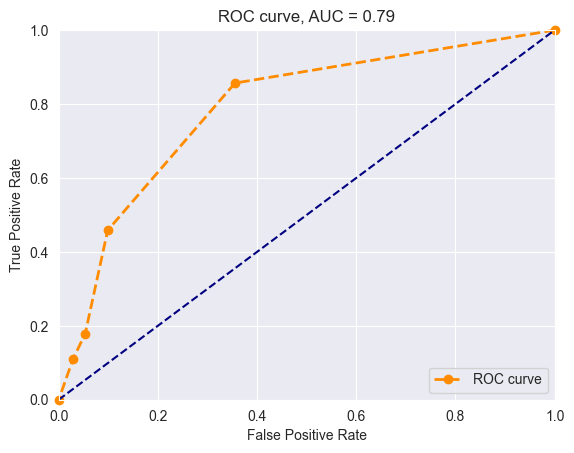

In [206]:
get_roc_auc(score, y)

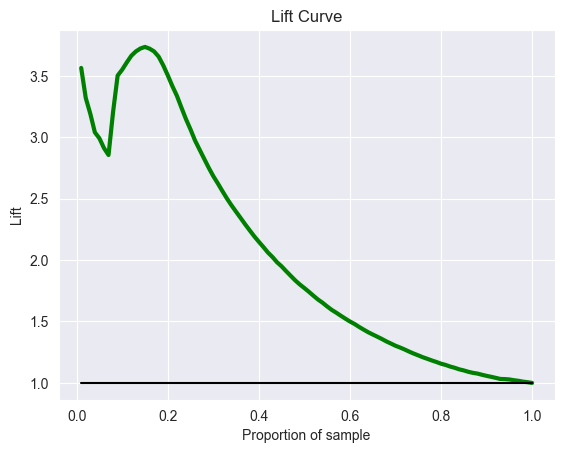

In [207]:
plot_lift_curve(score, y)

### DDE calculations

In [208]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,single_feat_drift,feat_pair_drift
3510,feat_16,feat_74,0.437974,0.140038,0.297936,0.554197,0.391476,0.162721,1,1,0,1
3538,feat_16,feat_147,0.025163,0.188696,0.213859,0.554197,0.054659,0.499538,1,0,1,0
3552,feat_16,feat_66,0.547067,0.258588,0.288480,0.554197,0.422684,0.131513,1,1,0,1
3551,feat_16,feat_30,0.210462,0.619057,0.408595,0.554197,0.339770,0.214428,1,1,0,1
3550,feat_16,feat_162,0.032094,0.159513,0.127418,0.554197,0.031267,0.522930,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19184,feat_157,feat_83,0.029193,0.003232,0.032424,0.021283,0.269461,0.248178,0,0,0,0
19183,feat_157,feat_81,0.041402,0.020669,0.020733,0.021283,0.319698,0.298415,0,1,1,0
19182,feat_157,feat_79,0.041032,0.016567,0.024465,0.021283,0.319312,0.298029,0,1,1,0
19181,feat_157,feat_98,0.244138,0.214240,0.029898,0.021283,0.286711,0.265428,0,0,0,0


In [209]:
m = 200
k_dde = (summary_df.feat_1_drift.sum() + summary_df.feat_2_drift.sum()) / (m-1)

In [210]:
k_dde

54.0

In [211]:
dde_df = pd.DataFrame()

In [212]:
dde_df['threshold'] = np.arange(0,1,0.1)

In [213]:
dde_df['num_corr_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].shape[0])
dde_df['num_drifting_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].feat_pair_drift.sum())
dde_df['dde_pr'] = m/k_dde * dde_df['num_drifting_feat_pairs']/dde_df['num_corr_feat_pairs']
dde_df['dde_lift'] = dde_df['dde_pr'] / dde_df.iloc[0].dde_pr

In [214]:
dde_df

,threshold,num_corr_feat_pairs,num_drifting_feat_pairs,dde_pr,dde_lift
0,0.0,19900,1431,0.266332,1.000000
1,0.1,13596,1302,0.354679,1.331721
2,0.2,7792,1226,0.582744,2.188039
3,0.3,4143,1023,0.914528,3.433793
4,0.4,2482,656,0.978900,3.675492
5,0.5,1680,401,0.884039,3.319315
6,0.6,1245,256,0.761565,2.859460
7,0.7,962,203,0.781551,2.934502
8,0.8,697,158,0.839577,3.152374
9,0.9,413,100,0.896781,3.367157


<AxesSubplot:>

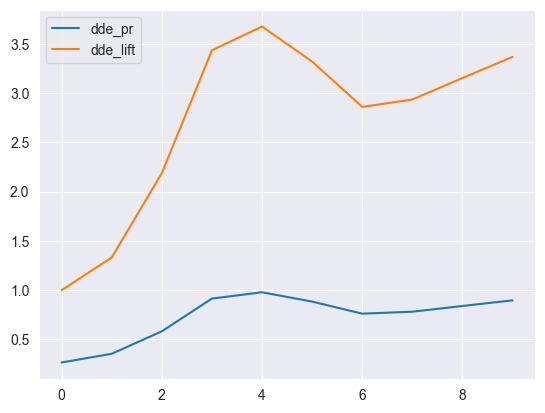

In [215]:
dde_df[['dde_pr', 'dde_lift']].plot()

In [216]:
dde_fitted_coeffs = np.polyfit(dde_df.threshold, dde_df.dde_lift, 2)
dde_fitted_curve = np.poly1d(dde_fitted_coeffs)

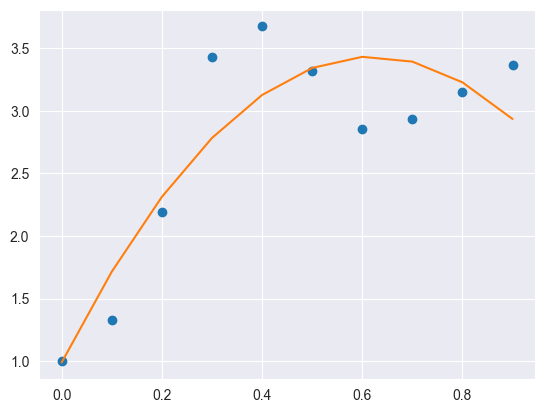

In [217]:
plt.plot(dde_df.threshold, dde_df.dde_lift, 'o', dde_df.threshold, dde_fitted_curve(dde_df.threshold))
plt.show()

### Cross validation test on Excel extract - JS

In [59]:
import random

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve

In [61]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    print(f'model 1 AUC score: {roc_auc_score(true_y, y_prob)}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [309]:
d2_df = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\cross_valid_test.xlsx', sheet_name='d2')
feat_1_drift_gt = d2_df.groupby('feature_1').agg({'feat_1_drift': 'max'}).rename(columns={'feat_1_drift': 'drift_gt'})

In [310]:
measurement_df = pd.DataFrame(index=pd.Index(pd.Series(['f1_score'])))
measurement_df_probs = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))
measurement_df_ddescore = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))

In [311]:
max_num_chkfts = 199
num_kfold = 10

In [312]:
for num_chkfts in range(1, max_num_chkfts+1):
    for k in range(1, num_kfold+1):
        feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]
        d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

        d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum', 'feat2_drift_prob_local': 'sum'})

        d2_df_filt_agg['pred_prob'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: x/num_chkfts)
        d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x / num_chkfts >= 0.5 else 0)

        feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred', 'pred_prob', 'feat2_drift_prob_local']], left_index=True, right_index=True, how='left')
        feat_1_drift_gt = feat_1_drift_gt.fillna(0)


        feat_1_drift_gt.sort_values(by='feat2_drift_prob_local', ascending=False, inplace=True)

        measurement_df[f'chkfeats{num_chkfts}_fold{k}'] = f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'])
        measurement_df_probs[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred_prob'])
        measurement_df_ddescore[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['feat2_drift_prob_local'])


        #plot_roc_curve(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred_prob'])

        feat_1_drift_gt = feat_1_drift_gt.drop(columns=['pred', 'pred_prob', 'feat2_drift_prob_local'])

In [313]:
idx = measurement_df.columns.str.split('_', expand=True)
measurement_df.columns = pd.MultiIndex.from_tuples(idx)

idx_probs = measurement_df_probs.columns.str.split('_', expand=True)
measurement_df_probs.columns = pd.MultiIndex.from_tuples(idx_probs)

idx_dde = measurement_df_ddescore.columns.str.split('_', expand=True)
measurement_df_ddescore.columns = pd.MultiIndex.from_tuples(idx_dde)

In [314]:
measurement_agg = pd.DataFrame()
measurement_agg['f1_avg'] = measurement_df.mean(level=0, axis='columns').T
measurement_agg['f1_std'] = measurement_df.std(level=0, axis='columns').T

measurement_agg_probs = pd.DataFrame()
measurement_agg_probs['auc_avg'] = measurement_df_probs.mean(level=0, axis='columns').T
measurement_agg_probs['auc_std'] = measurement_df_probs.std(level=0, axis='columns').T

measurement_agg_dde = pd.DataFrame()
measurement_agg_dde['auc_avg'] = measurement_df_ddescore.mean(level=0, axis='columns').T
measurement_agg_dde['auc_std'] = measurement_df_ddescore.std(level=0, axis='columns').T

<AxesSubplot:>

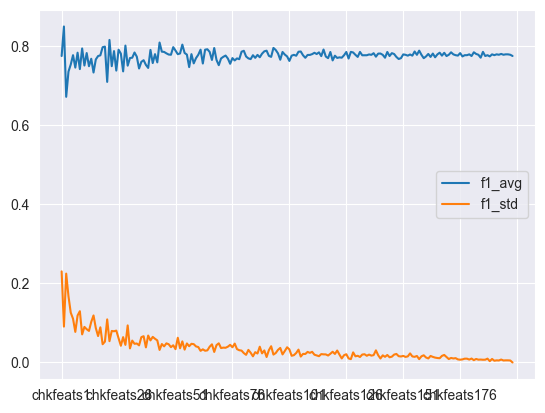

In [315]:
measurement_agg.plot()

<AxesSubplot:>

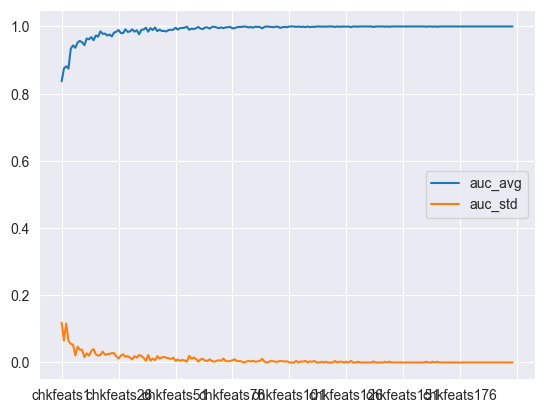

In [316]:
measurement_agg_probs.plot()

<AxesSubplot:>

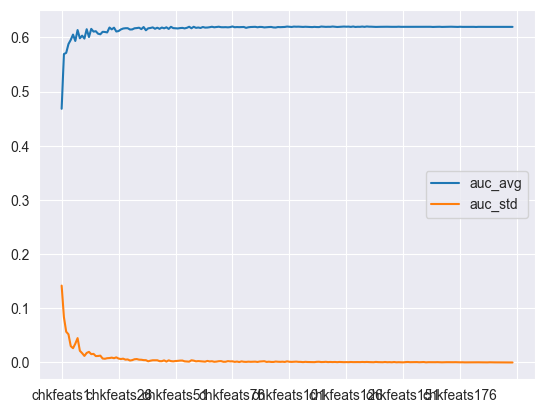

In [317]:
measurement_agg_dde.plot()

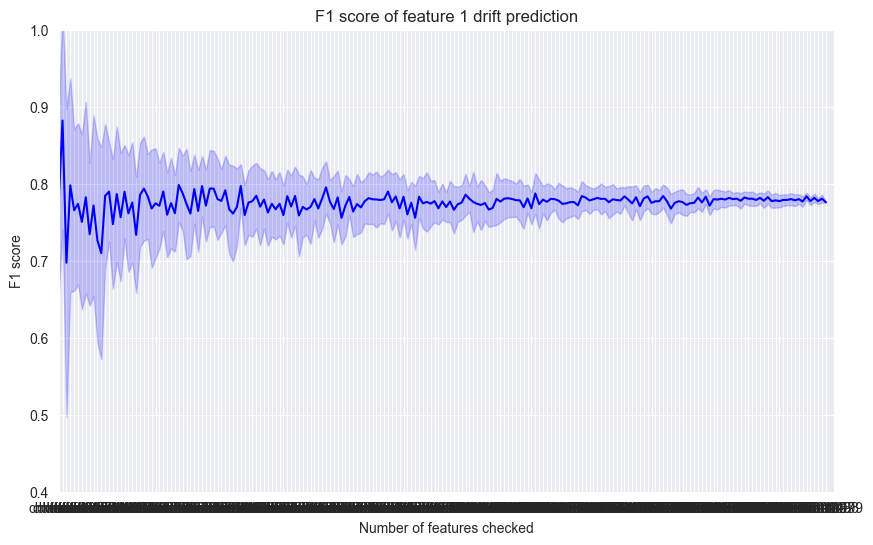

In [53]:
# plot mean with std on shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(measurement_agg['f1_avg'], color='blue')
ax.fill_between(measurement_agg.index, measurement_agg['f1_avg'] - measurement_agg['f1_std'], measurement_agg['f1_avg'] + measurement_agg['f1_std'], color='blue', alpha=0.2)
ax.set_xlabel('Number of features checked')
ax.set_ylabel('F1 score')
ax.set_title('F1 score of feature 1 drift prediction')
ax.set_ylim(0.4, 1)
ax.set_xlim(0, 200)
plt.show()

### Cross validation test on Excel extract - ADWIN

In [94]:
d2_df = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\CD_delta_vs_ro_chp_tabs_insects_adwin.xlsx',
                      sheet_name='d2')

In [97]:
feat_1_drift_gt = d2_df.groupby('feature_1').agg({'feat_1_drift': 'max'}).rename(columns={'feat_1_drift': 'drift_gt'})
measurement_df = pd.DataFrame(index=pd.Index(pd.Series(['f1_score'])))
measurement_df_probs = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))
measurement_df_ddescore = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))
max_num_chkfts = 199
num_kfold = 10


for num_chkfts in range(1, max_num_chkfts + 1):
    for k in range(1, num_kfold + 1):
        feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]
        d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

        d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum', 'feat2_drift_prob_local': 'sum'})

        d2_df_filt_agg['pred_prob'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: x / num_chkfts)
        d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x / num_chkfts >= 0.5 else 0)

        feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred', 'pred_prob', 'feat2_drift_prob_local']],
                                                left_index=True, right_index=True, how='left')
        feat_1_drift_gt = feat_1_drift_gt.fillna(0)

        feat_1_drift_gt.sort_values(by='feat2_drift_prob_local', ascending=False, inplace=True)

        measurement_df[f'chkfeats{num_chkfts}_fold{k}'] = f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'])
        measurement_df_probs[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'],
                                                                              feat_1_drift_gt['pred_prob'])
        measurement_df_ddescore[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'],
                                                                                 feat_1_drift_gt[
                                                                                     'feat2_drift_prob_local'])

        #plot_roc_curve(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred_prob'])

        feat_1_drift_gt = feat_1_drift_gt.drop(columns=['pred', 'pred_prob', 'feat2_drift_prob_local'])


idx = measurement_df.columns.str.split('_', expand=True)
measurement_df.columns = pd.MultiIndex.from_tuples(idx)

idx_probs = measurement_df_probs.columns.str.split('_', expand=True)
measurement_df_probs.columns = pd.MultiIndex.from_tuples(idx_probs)

idx_dde = measurement_df_ddescore.columns.str.split('_', expand=True)
measurement_df_ddescore.columns = pd.MultiIndex.from_tuples(idx_dde)
measurement_agg = pd.DataFrame()
measurement_agg['f1_avg'] = measurement_df.mean(level=0, axis='columns').T
measurement_agg['f1_std'] = measurement_df.std(level=0, axis='columns').T

measurement_agg_probs = pd.DataFrame()
measurement_agg_probs['auc_avg'] = measurement_df_probs.mean(level=0, axis='columns').T
measurement_agg_probs['auc_std'] = measurement_df_probs.std(level=0, axis='columns').T

measurement_agg_dde = pd.DataFrame()
measurement_agg_dde['auc_avg'] = measurement_df_ddescore.mean(level=0, axis='columns').T
measurement_agg_dde['auc_std'] = measurement_df_ddescore.std(level=0, axis='columns').T

<AxesSubplot:>

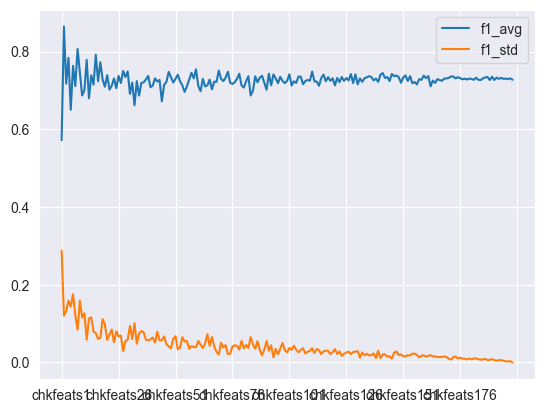

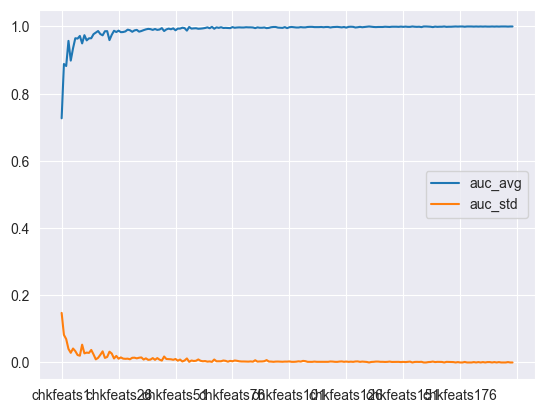

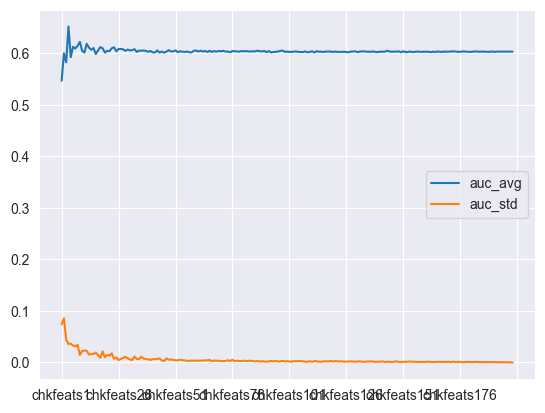

In [98]:
measurement_agg.plot()
measurement_agg_probs.plot()
measurement_agg_dde.plot()

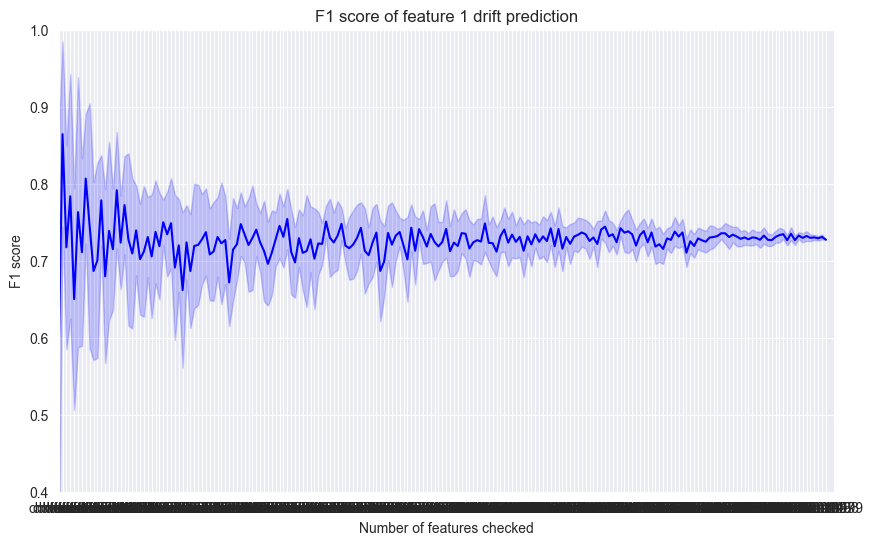

In [99]:
# plot mean with std on shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(measurement_agg['f1_avg'], color='blue')
ax.fill_between(measurement_agg.index, measurement_agg['f1_avg'] - measurement_agg['f1_std'],
                measurement_agg['f1_avg'] + measurement_agg['f1_std'], color='blue', alpha=0.2)
ax.set_xlabel('Number of features checked')
ax.set_ylabel('F1 score')
ax.set_title('F1 score of feature 1 drift prediction')
ax.set_ylim(0.4, 1)
ax.set_xlim(0, 200)
plt.show()